In [1]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data as mdmask
import ingest_tif_stack as ingest

In [2]:
import registerer_copy as reg
import preprocessor_copy as pre
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

In [3]:
atlas_resolution = 50
atlas = ndreg.imgRead('./atlas/ara_atlas.img')
atlas_width, atlas_height, atlas_depth = atlas.GetSize()

full_img = ndreg.imgRead('./missing_insula/whole_insula.img')
orientation_atlas = 'pir'
orientation_image = 'lps'
full_img = ndreg.imgReorient(full_img, orientation_image, orientation_atlas)
full_img_width, full_img_height, ful_img_depth = full_img.GetSize()

missing_img = ndreg.imgRead('./missing_insula/missing_ant_insula_15.img')
img_width, img_height, img_depth = missing_img.GetSize()

padded_img, padded_mask = mdmask.pad_img_with_range(missing_img, width_range=(abs(img_width-full_img_width),0))

# Inputs

## Atlas

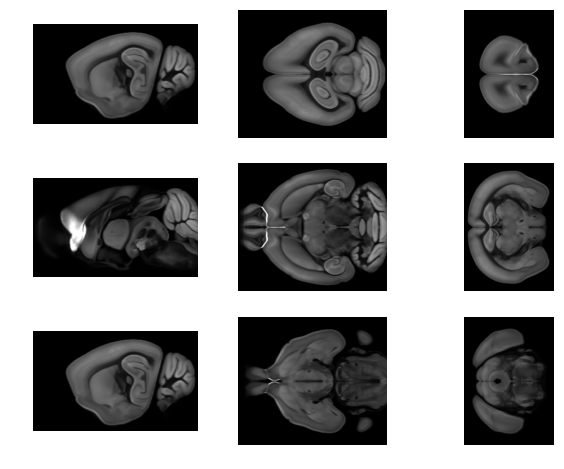

In [4]:
ndreg.imgShow(atlas)

## Insula with partially missing nose

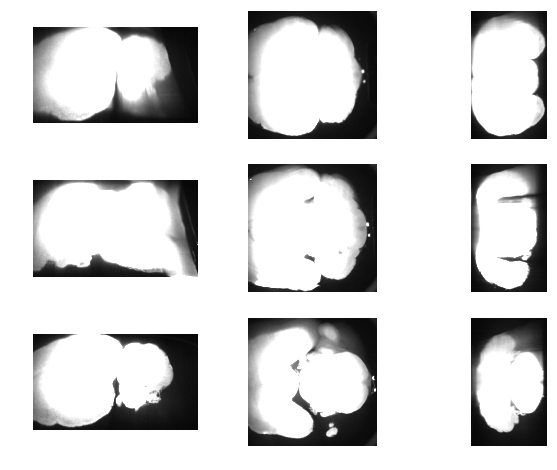

In [5]:
ndreg.imgShow(missing_img, vmax=2500)

## Scenario of known missing data: pad image with an estimate of how much is missing

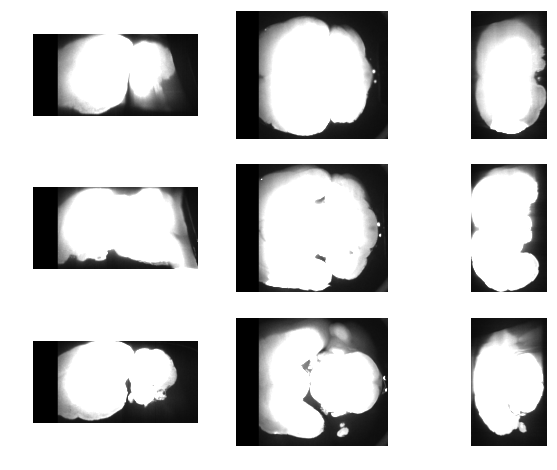

In [6]:
ndreg.imgShow(padded_img, vmax=2500)

In [7]:
# Bias correction
mask_dilation_radius = 10 # voxels
mask_bc = sitk.BinaryDilate(pre.create_mask(padded_img, use_triangle=True), mask_dilation_radius)
img_bc, bias = pre.correct_bias_field(padded_img, scale=0.25, spline_order=4, mask=mask_bc,
                                     num_control_pts=[5,5,5],
                                     niters=[50, 50, 50, 50])
atlas_n = sitk.Normalize(atlas)
img_bc_n = sitk.Normalize(img_bc)

## With no mask

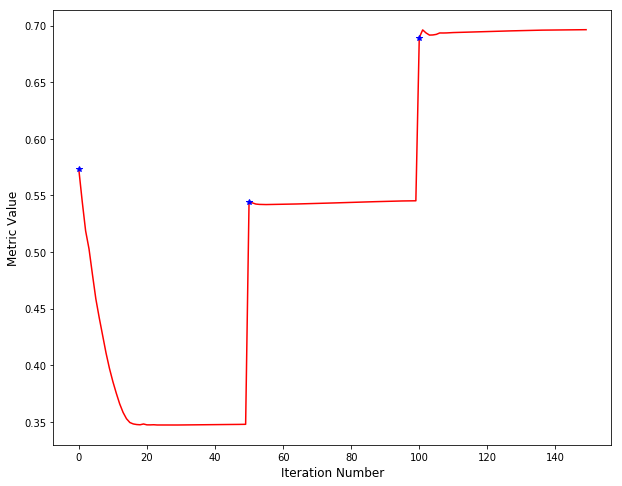

In [8]:
# Compute affine transform
final_transform_no_mask = reg.register_affine(atlas_n,
                                    img_bc_n,
                                    learning_rate=1e-1,
                                    grad_tol=4e-6,
                                    use_mi=False,
                                    iters=50,
                                    shrink_factors=[4,2,1],
                                    sigmas=[0.4, 0.2, 0.1],
                                    verbose=True)

In [9]:
atlas_affine_no_mask = reg.resample(atlas, final_transform_no_mask, img_bc, default_value=ndreg.imgPercentile(atlas,0.01))


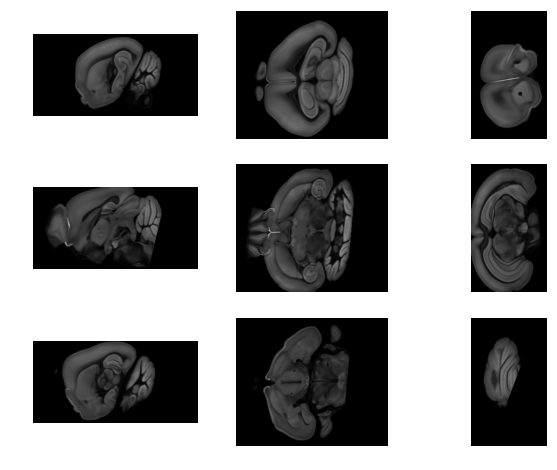

In [10]:
ndreg.imgShow(atlas_affine_no_mask)

In [11]:
# whiten the images
atlas_affine_w_no_mask = sitk.AdaptiveHistogramEqualization(atlas_affine_no_mask, [10,10,10], alpha=0.25, beta=0.25)
img_bc_w = sitk.AdaptiveHistogramEqualization(img_bc, [10,10,10], alpha=0.25, beta=0.25)

In [12]:
# LDDMM
e = 5e-3
s = 0.1
atlas_lddmm_no_mask, field, inv_field = reg.register_lddmm(affine_img=sitk.Normalize(atlas_affine_w_no_mask), 
                                                          target_img=sitk.Normalize(img_bc_w),
                                                          alpha_list=[0.05], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=e, sigma=s,
                                                          min_epsilon_list=e*1e-6,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	77121.5, 170.681, 0, 76950.8 (90.6814%), 5.500000e-03
1.	76619.1, 250.876, 0, 76368.2 (89.9949%), 3.025000e-03
2.	76086.4, 375.579, 0, 75710.9 (89.2203%), 3.327500e-03
3.	75716.5, 418.051, 0, 75298.5 (88.7343%), 1.830125e-03
4.	68383.2, 485.819, 0, 67897.4 (80.0126%), 2.013138e-03
5.	67513.9, 505.915, 0, 67008 (78.9645%), 5.536128e-04
E = 67513.9 (78.9645%)
Length = 22.3292
Time = 58.5226s (0.975377m)

Step 1: alpha=0.05, beta=0.05, scale=0.125
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	74236, 29.9813, 0, 74206 (96.6532%), 5.500000e-03
1.	72615.2, 69.4548, 0, 72545.8 (94.4907%), 6.050000e-03
2.	72448.4, 149.832, 0, 72298.6 (94.1687%), 6.655000e-03
3.	72446.6, 150.122, 0, 72296.4 (94.166%), 5.719141e-05
4.	72446, 150.142, 0, 72295.8 (94.1652%), 3.931909e-06
5.	72445.7, 150.153, 0, 72295.5 (94.1648%), 2.162550e-06
6.	72445.6, 150.156, 0, 72295.4 (94.1647%), 5.947013

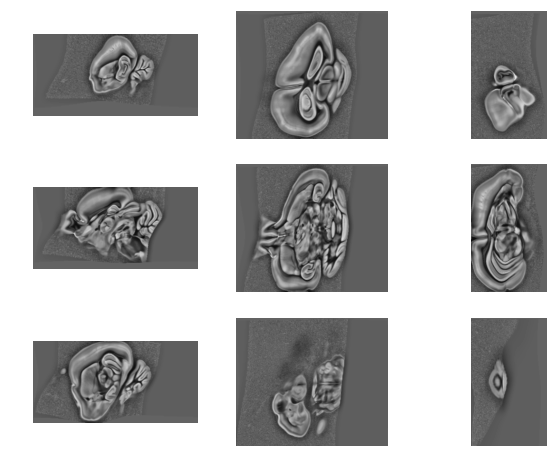

In [13]:
ndreg.imgShow(atlas_lddmm_no_mask)

## With mask

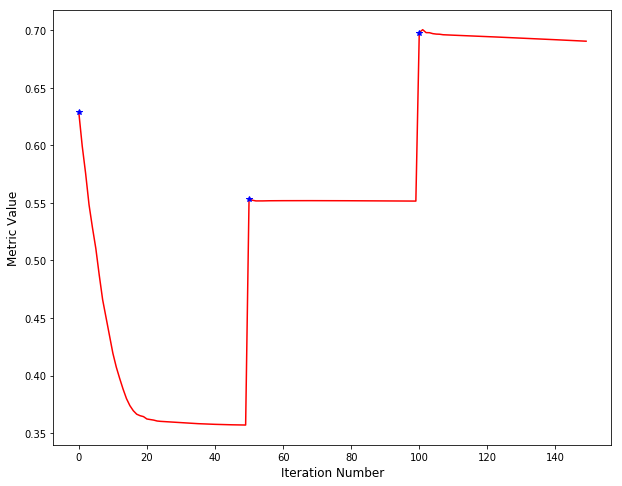

In [14]:
# Compute affine transform
final_transform_with_mask = reg.register_affine(atlas_n,
                                    img_bc_n,
                                    fixed_mask=padded_mask,
                                    learning_rate=1e-1,
                                    grad_tol=4e-6,
                                    use_mi=False,
                                    iters=50,
                                    shrink_factors=[4,2,1],
                                    sigmas=[0.4, 0.2, 0.1],
                                    verbose=True)

In [15]:
atlas_affine_with_mask = reg.resample(atlas, final_transform_with_mask, img_bc, default_value=ndreg.imgPercentile(atlas,0.01))


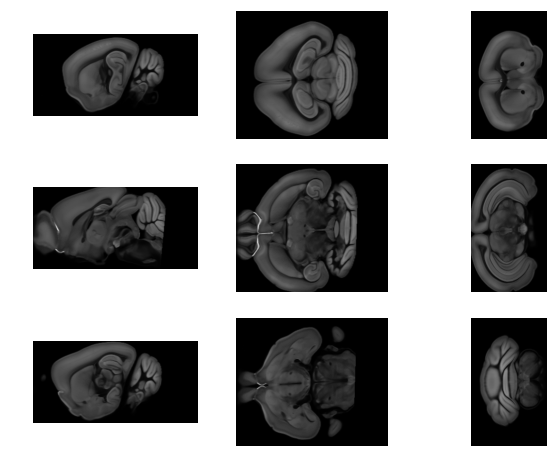

In [16]:
ndreg.imgShow(atlas_affine_with_mask)

In [20]:
# whiten the images
atlas_affine_w_with_mask = sitk.AdaptiveHistogramEqualization(atlas_affine_with_mask, [10,10,10], alpha=0.25, beta=0.25)
img_bc_w = sitk.AdaptiveHistogramEqualization(img_bc, [10,10,10], alpha=0.25, beta=0.25)

In [21]:
# LDDMM
e = 5e-3
s = 0.1
atlas_lddmm_with_mask, field, inv_field = reg.register_lddmm(affine_img=sitk.Normalize(atlas_affine_w_with_mask), 
                                                          target_img=sitk.Normalize(img_bc_w),
                                                          alpha_list=[0.05],
                                                          refMask=padded_mask,
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=e, sigma=s,
                                                          min_epsilon_list=e*1e-6,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.05, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	77224.4, 188.42, 0, 77035.9 (91.6446%), 5.500000e-03
1.	75519.1, 405.944, 0, 75113.1 (89.3572%), 6.050000e-03
2.	75492.7, 410.519, 0, 75082.2 (89.3203%), 2.079688e-04
E = 75492.7 (89.3203%)
Length = 28.7678
Time = 37.406s (0.623433m)

Step 1: alpha=0.05, beta=0.05, scale=0.125
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	72422, 29.0585, 0, 72392.9 (93.1907%), 5.500000e-03
1.	71118.7, 57.0671, 0, 71061.6 (91.4769%), 6.050000e-03
2.	70407.3, 123.008, 0, 70284.3 (90.4763%), 6.655000e-03
3.	70382.7, 158.223, 0, 70224.5 (90.3993%), 3.660250e-03
4.	69555.1, 213.934, 0, 69341.2 (89.2623%), 4.026275e-03
5.	69182, 237.21, 0, 68944.7 (88.7519%), 2.214451e-03
6.	68495.8, 273.193, 0, 68222.6 (87.8223%), 2.435896e-03
7.	68426.6, 292.296, 0, 68134.3 (87.7086%), 1.339743e-03
8.	68342.8, 314.938, 0, 68027.9 (87.5716%), 1.473717e-03
9.	68122.5, 340.991, 0, 67781.5 (87.2544%), 1.6210

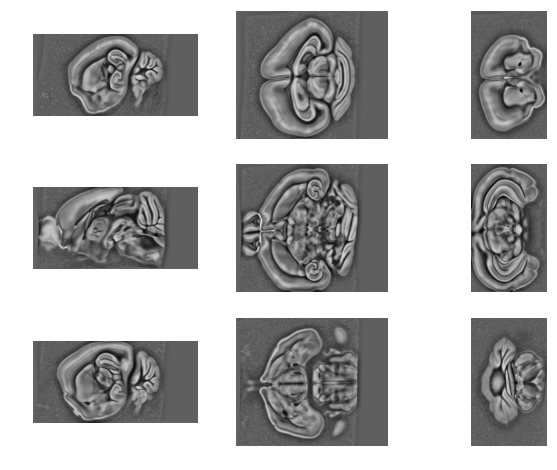

In [22]:
ndreg.imgShow(atlas_lddmm_with_mask)

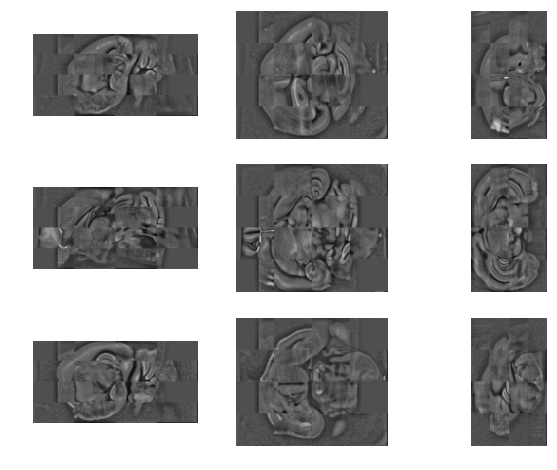

In [24]:
ndreg.imgShow(ndreg.imgChecker(atlas_lddmm_with_mask, img_bc_w))

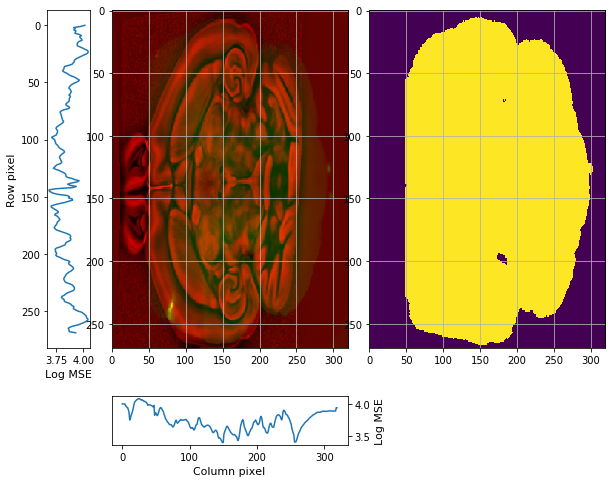

In [29]:
atlas_lddmm_with_mask_slice = sitk.GetArrayFromImage(sitk.Normalize(atlas_lddmm_with_mask))[:,75,:]
img_rigid_slice = sitk.GetArrayFromImage(sitk.Normalize(img_bc))[:,75,:]
side_img_slice = sitk.GetArrayFromImage(pre.create_mask(padded_img, use_triangle=True))[:,75,:]
mdmask.plot_mse(atlas_lddmm_with_mask_slice, img_rigid_slice, side_img=side_img_slice, color_blend=True)

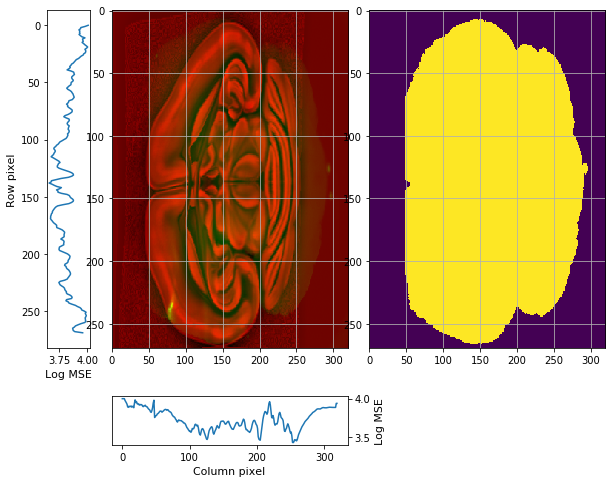

In [30]:
atlas_lddmm_with_mask_slice = sitk.GetArrayFromImage(sitk.Normalize(atlas_lddmm_with_mask))[:,50,:]
img_rigid_slice = sitk.GetArrayFromImage(sitk.Normalize(img_bc))[:,50,:]
side_img_slice = sitk.GetArrayFromImage(pre.create_mask(padded_img, use_triangle=True))[:,50,:]
mdmask.plot_mse(atlas_lddmm_with_mask_slice, img_rigid_slice, side_img=side_img_slice, color_blend=True)